# Forward-Forward Algorithm

https://arxiv.org/pdf/2212.13345.pdf  
https://medium.com/@dansek.dj/supervised-and-unsupervised-learning-using-the-forward-forward-algorithm-9282767798b3  



backpropagation에 의한 기존의 forward - backward 방식을 forward - forward 방식으로 대체하여 학습하는 새로운 방법  

positive data (real data), negative data (generated data) 를 이용하며 각각의 레이어가 objective를 가짐 (goodness)  



## What is wrong with backpropagation

실제 뇌가 학습(추론)하는 방식에서 backward pass는 존재하지 않고, 어떤 루프를 형성한다고 함.

## Forward-Forward Algorithm

forward, backward를 같은 연산을 하는 두개의 forward 로 변경, 이때 data에 차이를 둔다.  

**positive pass** : real data에 대하여 goodness가 커지도록 가중치를 업데이트  
**negatibe pass** : negative data에 대하여 goodness 가 감소하도록 가중치를 업데이트  

본 논문에서는 goodness는 hidden layer의 activation에 대한 제곱합 또는 negative sum 으로 정의했음  

학습의 목적은 real data 의 goodness를 어떤 임계값보다 크게, negative data 의 goodness를 임계값보다 작게만들어 input vector를 정확하게 분류  

$$ P(positive) = σ(Σy_j^2-θ) $$  

여러 hidden layer를 사용하기 위해 normalization 사용

## Some experiments with FF

대부분 MNIST로 실험, backprop을 사용한 CNN기반의 모델들이 0.6%의 test error를 보여주는데 비해 1.4%의 test error를 기록하므로써 괜찮은 성능을 보여줌  

### A simple unsupervised example of FF

contrastive learning을 이용,  
먼저 label의 정보 없이 input vector를 representation vector 로 변환하는 mapping을 학습 이때 negative data로 hybrid image를 사용  
후에 representation vector를 logit 으로 변환하는 mapping을 학습하여 분류 수행

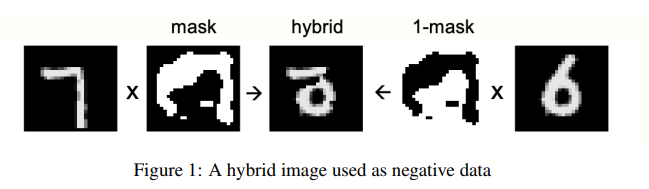

MNIST 실험 > test error는 1.57%

### A simple supervised example of FF

supervised learning의 경우 마스킹없이 image에 label을 그대로 추가해줌.  
real data에는 맞는 label, negative data에는 틀린 label을 추가하여 학습  
학습 후에는 처음 10개의 픽셀을 0.1로 채우고 예측하나 class 별로 label를 붙여서 예측하는것이 정확함  

MNIST 실험 > test error는 1.36%

#### 예제 코드

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader =  MNIST_loaders()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :10] *= 0.0
    # x.shape[0] : batch_size
    x_[range(x.shape[0]), y] = x.max()
    return x_

In [11]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super(Layer, self).__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.optim = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 500

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.optim.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.optim.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [12]:
class Net(nn.Module):
  def __init__(self, dims, device):
      super(Net, self).__init__()
      self.layers = []
      for d in range(len(dims) - 1):
          self.layers += [Layer(dims[d], dims[d + 1]).to(device)]

  def predict(self, x):
      goodness_per_label = []
      for label in range(10):
          h = overlay_y_on_x(x, label)
          goodness = []
          for layer in self.layers:
              h = layer(h)
              goodness += [h.pow(2).mean(1)]
          goodness_per_label += [sum(goodness).unsqueeze(1)]
      goodness_per_label = torch.cat(goodness_per_label, 1)
      return goodness_per_label.argmax(1)

  def train(self, x_pos, x_neg):
      h_pos, h_neg = x_pos, x_neg
      for i, layer in enumerate(self.layers):
          print('training layer', i, '...')
          h_pos, h_neg = layer.train(h_pos, h_neg)

In [13]:
def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

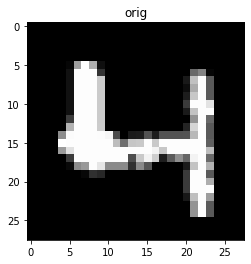

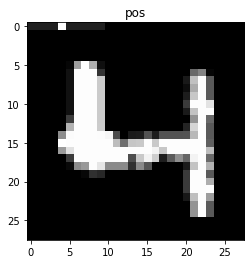

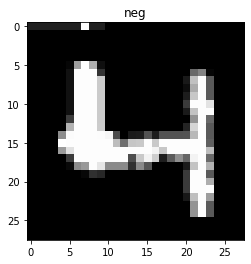

In [14]:
torch.manual_seed(1234)

net = Net([784, 500, 500], device = device)
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])

for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    visualize_sample(data, name)

In [15]:
net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

training layer 0 ...


100%|██████████| 500/500 [33:15<00:00,  3.99s/it]


training layer 1 ...


100%|██████████| 500/500 [25:02<00:00,  3.00s/it]


train error: 0.10166001319885254


In [34]:
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)

print('test error: %.2f'%(1.0 - net.predict(x_te).eq(y_te).float().mean().item()))

test error: 0.10


### Using FF to model top-down effects in perception

###  Using predictions from the spatial context as a teacher

## Experiments with CIFAR-10



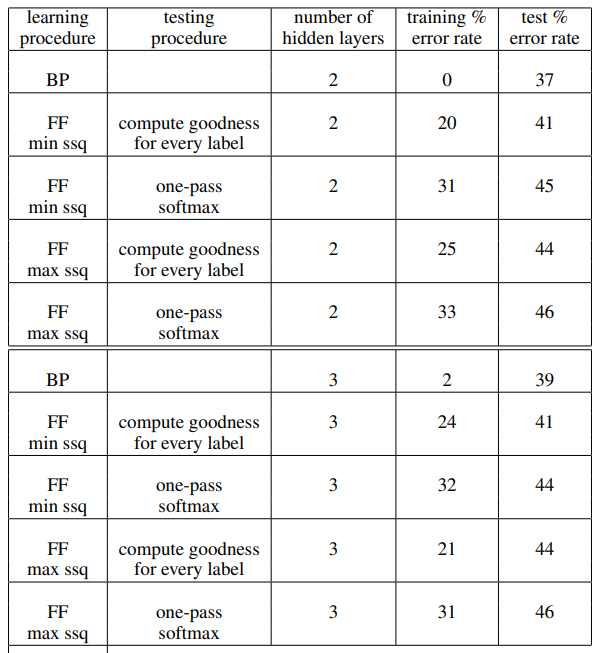

backprop이 전체적으로 우수하나 차이가 크게 나지 않는다는 점을 확인